# Imports

In [1]:
# Common imports
import sys
import os
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [2]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Load the data

In [3]:
cifar10_mnist = keras.datasets.cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10_mnist.load_data()

In [4]:
X_train_full.shape

(50000, 32, 32, 3)

In [5]:
X_test.shape

(10000, 32, 32, 3)

In [6]:
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_train.shape

(45000, 32, 32, 3)

In [7]:
# Compute the mean for each pixel.
pixel_means = X_train.mean(axis=0)
pixel_means.shape

(32, 32, 3)

In [8]:
# Compute the standard deviation for each pixel.
pixel_stds = X_train.std(axis=0)

In [9]:
# Scale the inputs to mean 0 and standard deviation 1 to achieve self-normalization with SELU and LeCun.
X_train_standardized = (X_train - pixel_means) / pixel_stds

X_valid_standardized = (X_valid - X_valid.mean(axis=0)) / X_valid.std(axis=0)
X_test_standardized = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)

In [10]:
X_train_standardized.shape

(45000, 32, 32, 3)

In [11]:
# Validate that the mean is close to 0 for each pixel.
X_train_standardized.mean(axis=0)

array([[[-9.20695619e-17, -2.96059473e-19, -1.45769816e-16],
        [ 7.32796539e-17,  1.12759185e-16,  1.99988174e-17],
        [ 5.81855551e-17, -5.07840683e-17, -1.16716513e-16],
        ...,
        [-1.18033978e-16, -1.13918751e-16, -2.95368668e-17],
        [ 6.35047570e-17,  2.42966141e-17, -5.25653595e-17],
        [ 1.02747440e-16, -1.42118416e-16,  1.57404953e-17]],

       [[ 1.43771415e-16, -2.12008189e-16, -3.04645198e-17],
        [-1.63933065e-16, -1.15739517e-16, -6.46741919e-17],
        [-1.05939948e-16, -3.68791417e-17,  1.78430110e-16],
        ...,
        [-7.20115325e-17, -8.79099263e-17,  1.03719502e-17],
        [ 4.34832417e-16,  1.16859608e-16,  2.03146142e-17],
        [-3.50213685e-16, -2.16286248e-16,  1.62240591e-17]],

       [[ 8.97899039e-17,  7.61810368e-17, -6.74818226e-17],
        [-2.00200350e-16,  9.11271059e-17,  4.35651515e-17],
        [-1.97624633e-16, -1.41481888e-16,  6.19652477e-17],
        ...,
        [ 1.82125919e-16, -1.74290212e-16,

In [12]:
# Validate that the standard deviation is close to 1 for each pixel.
X_train_standardized.std(axis=0)

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

# Create a model using the Sequential API

In [13]:
model = keras.models.Sequential()
# Input layer:
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))

# Hidden layers:
for layer in range(14):
    model.add(keras.layers.Dense(80, activation="selu", kernel_initializer="lecun_normal"))

# Use alpha dropout in the last hidden layer.
model.add(keras.layers.AlphaDropout(rate=0.20))
    
# Output layer.
model.add(keras.layers.Dense(10, activation="softmax"))

# Compile the model

In [14]:
# The optimixer is Stochastic Gradient Descent with momentum optimization. The momentum is set to 0.9.
# This value usually works well in practice. We use the default learning rate (0.01).
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(momentum=0.9),
              metrics=["accuracy"])

In [15]:
# EarlyStopping (with rollback to the best model).
early_stopping = keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)

# Performance scheduling
# (multiply the learning rate by a factor when the error stops dropping for a number of epochs, called patience)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)

# Train the model with early stopping or performance scheduling or both. Training is much faster when
# early stopping is used, but a slightly better accuracy is achieved with performance scheduling alone.
history = model.fit(X_train_standardized, y_train, epochs=40,
                    validation_data=(X_valid_standardized, y_valid),
                    callbacks=[lr_scheduler, early_stopping])

Epoch 1/40
1407/1407 [==============================] - 3s 2ms/step - loss: 1.9701 - accuracy: 0.2872 - val_loss: 1.8836 - val_accuracy: 0.3546
Epoch 2/40
1407/1407 [==============================] - 3s 2ms/step - loss: 1.7301 - accuracy: 0.3827 - val_loss: 1.6884 - val_accuracy: 0.4094
Epoch 3/40
1407/1407 [==============================] - 3s 2ms/step - loss: 1.6336 - accuracy: 0.4241 - val_loss: 1.6278 - val_accuracy: 0.4342
Epoch 4/40
1407/1407 [==============================] - 3s 2ms/step - loss: 1.5710 - accuracy: 0.4484 - val_loss: 1.6390 - val_accuracy: 0.4314
Epoch 5/40
1407/1407 [==============================] - 3s 2ms/step - loss: 1.5205 - accuracy: 0.4680 - val_loss: 1.5862 - val_accuracy: 0.4672
Epoch 6/40
1407/1407 [==============================] - 3s 2ms/step - loss: 1.4755 - accuracy: 0.4888 - val_loss: 1.6140 - val_accuracy: 0.4626
Epoch 7/40
1407/1407 [==============================] - 3s 2ms/step - loss: 1.4403 - accuracy: 0.5008 - val_loss: 1.6281 - val_accuracy:

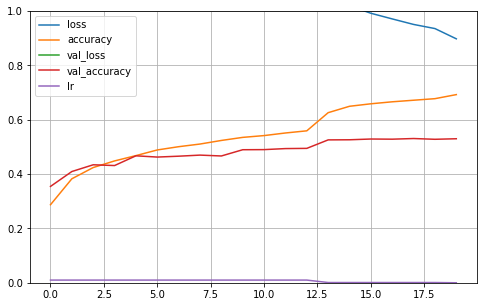

In [16]:
# Show the learning curves.
# (The training curves should be shifted half an epoch to the left to be completely comparable with
# the validation curves).

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [17]:
model.evaluate(X_test_standardized, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 1.4817 - accuracy: 0.5232


[1.4816969633102417, 0.5231999754905701]